<a href="https://colab.research.google.com/github/palakagl/AI-in-Finance/blob/main/Frontier_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 63 kB 5.8 MB/s 
     |████████████████████████████████| 6.4 MB 31.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# Get Adjusted Close price for different stocks from Yahoo Finance 
def getQuotes(securities, start_date, end_date, quote_type, interval):
  quotes_df = yf.download(securities, 
                      start=start_date, 
                      end=end_date, 
                      time_interval=interval)[quote_type]
  return quotes_df

# List of Stocks
STOCKS_LIST = ['AMZN','GOOGL' , 'TSLA','GM','AAPL','FB', 'MCD','PFE']
daily_quote_df = getQuotes(STOCKS_LIST, '2016-01-01', '2020-12-31', 'Adj Close', 'monthly')
daily_quote_df

[*********************100%***********************]  8 of 8 completed


,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA
Date,,,,,,,,
2016-01-04,24.220579,636.989990,102.220001,27.775913,759.440002,100.447296,23.763653,44.681999
2016-01-05,23.613630,633.789978,102.730003,27.042112,761.530029,101.831245,23.934721,44.686001
2016-01-06,23.151514,632.650024,102.970001,26.074831,759.330017,101.147797,23.510765,43.807999
2016-01-07,22.174417,607.940002,97.919998,25.007490,741.000000,98.807068,23.354574,43.130001
2016-01-08,22.291666,607.049988,97.330002,24.623915,730.909973,98.653305,23.057062,42.200001
...,...,...,...,...,...,...,...,...
2020-12-23,129.992004,3185.270020,268.109985,42.450001,1728.229980,206.127609,35.758366,645.979980
2020-12-24,130.994522,3172.689941,267.399994,41.580002,1734.160034,205.515106,35.595997,661.770020
2020-12-28,135.679642,3283.959961,277.000000,41.660000,1773.959961,208.072006,35.166210,663.690002


# Calculate Covariance Using Montly Data

In [ ]:
# Get last day quote for every month
def convert_daily_to_monthly_quotes_dataframe(daily_quote_df):
  monthly_quote_df = daily_quote_df.resample('M').last()
  return monthly_quote_df

monthly_quote_df = convert_daily_to_monthly_quotes_dataframe(daily_quote_df)
monthly_quote_df

,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA
Date,,,,,,,,
2016-01-31,22.379028,587.000000,112.209999,24.715643,761.349976,105.743866,22.677736,38.240002
2016-02-29,22.350214,552.520020,106.919998,24.548862,717.219971,100.872566,22.301815,38.386002
2016-03-31,25.193403,593.640015,114.099998,26.536936,762.900024,108.180412,22.279261,45.953999
2016-04-30,21.668314,659.590027,117.580002,26.849331,707.880005,108.877625,24.586863,48.152000
2016-05-31,23.223511,722.789978,118.809998,26.410288,748.849976,105.064453,26.328978,44.646000
2016-06-30,22.232801,715.619995,114.279999,24.198400,703.530029,104.345337,26.715939,42.456001
2016-07-31,24.235151,758.809998,123.940002,26.968819,791.340027,102.012856,27.990662,46.958000
2016-08-31,24.808355,769.159973,126.120003,27.293745,789.849976,101.066757,26.636305,42.402000
2016-09-30,26.433416,837.309998,128.270004,27.490715,804.059998,100.804619,25.924473,40.806000


### Calculate Covariance
We will use monthly data from Jan 2016-Dec 2020, to calculate returns for all 8 stocks. We will use that to calculate covariance on Jan 1, 2021.

In [ ]:
# Convert price to change in price or returns
def calculate_returns(quotes_df):
  return quotes_df.pct_change()

# Generate Covariance or correlation between stocks, based on returns
def calculate_covariance(returns_dataframe):
  return returns_dataframe.cov()

returns_df = calculate_returns(monthly_quote_df)
cov_matrix_df = calculate_covariance(returns_df)
cov_matrix_df

,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA
AAPL,0.007533,0.003438,0.004001,0.002748,0.002956,0.001166,0.000736,0.008425
AMZN,0.003438,0.006508,0.004077,0.001100,0.002864,0.001167,0.001691,0.005158
FB,0.004001,0.004077,0.006591,0.004205,0.003148,0.001256,0.000955,0.006291
GM,0.002748,0.001100,0.004205,0.008582,0.003062,0.001705,0.001224,0.006538
GOOGL,0.002956,0.002864,0.003148,0.003062,0.003923,0.001121,0.000882,0.004914
MCD,0.001166,0.001167,0.001256,0.001705,0.001121,0.002462,0.000870,0.003934
PFE,0.000736,0.001691,0.000955,0.001224,0.000882,0.000870,0.003798,0.002428
TSLA,0.008425,0.005158,0.006291,0.006538,0.004914,0.003934,0.002428,0.036726


In [ ]:
returns_df

,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA
Date,,,,,,,,
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,-0.001288,-0.058739,-0.047144,-0.006748,-0.057963,-0.046067,-0.016577,0.003818
2016-03-31,0.127211,0.074423,0.067153,0.080984,0.063690,0.072446,-0.001011,0.197155
2016-04-30,-0.139921,0.111094,0.030500,0.011772,-0.072120,0.006445,0.103576,0.047830
2016-05-31,0.071773,0.095817,0.010461,-0.016352,0.057877,-0.035023,0.070856,-0.072811
2016-06-30,-0.042660,-0.009920,-0.038128,-0.083751,-0.060519,-0.006845,0.014697,-0.049053
2016-07-31,0.090063,0.060353,0.084529,0.114488,0.124813,-0.022353,0.047714,0.106039
2016-08-31,0.023652,0.013640,0.017589,0.012048,-0.001883,-0.009274,-0.048386,-0.097023
2016-09-30,0.065505,0.088603,0.017047,0.007217,0.017991,-0.002594,-0.026724,-0.037640


#Defining Functions To Run This Model

In [ ]:
#Function to extract stock prices for specific stock from whole dataset
def getStockQuotesFromDataframe(original_df, stockName):
  stock_df = original_df[[stockName]].copy()
  return stock_df

#stock_info_df = getStockQuotesFromDataframe(monthly_quote_df, 'AAPL')
#stock_info_df.head()

### Data Pre-processing

In [ ]:
# Using minmax scaler to scale data
scaler = MinMaxScaler(feature_range=(0,1))

def min_max_scale_data(quotes_dataframe):
  scaled_quote_df = quotes_dataframe.copy()
  scaled_quotes = scaler.fit_transform(scaled_quote_df)
  return scaled_quotes

#scaled_quotes_arr = min_max_scale_data(stock_info_df)
#scaled_quotes_arr[0:4,0]

In [ ]:
#Split Dataset into train and test
def preprocess_data(dataset_arr, split_ratio, window):
  training_size = round(len(dataset_arr) * split_ratio)
  train_data = dataset_arr [:training_size]
  test_data  = dataset_arr [training_size-window:]
  return train_data, test_data, training_size

### Converting Stock Prices Into Feature Columns and Label
To prepare input for our machine learning model, we need data to be split into X and Y arrays. 
We will start from Jan 2016 monthly stock value, putting it in 'X' (feature), and will use Feb 2016 monthly stock value for 'Y' (label), and, so on until Dec 2020. We will predict stock price for Jan 2021, using this format.

In [ ]:
# Split data array into X & Y to use as input for machine learning model.
def split_data_X_Y(data_array, window):
  X_train = []
  y_train = []
  for i in range(window, len(data_array)):
    X_train.append(data_array[i-window:i, 0])
    y_train.append(data_array[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  return X_train, y_train

#WINDOW_SIZE=1
#TRAIN_SIZE=0.80
#train_data_arr, test_data_arr, training_size = preprocess_data(scaled_quotes_arr, TRAIN_SIZE, WINDOW_SIZE)
#print("Train Data Shape:",train_data_arr.shape)
#print("Test Data Shape:",test_data_arr.shape)
#print("Train Data Sample:",train_data_arr[0:4,0])

#X_train, y_train = split_data_X_Y(train_data_arr, WINDOW_SIZE)
#print("X_train Shape:",X_train.shape)
#print("y_train Shape:",y_train.shape)
#print("X_train Sample:",X_train[0:5,0])
#print("y_train Sample:",y_train[0:5])

### Modelling

In [ ]:
#Build the LSTM model
def build_model(params={}):
  model=Sequential()
  model.add(LSTM(params['LSTM_1_units'],return_sequences=True, input_shape=(params['window_size'],1))) # Use X_train.shape[1], instead of window_size, if running standalone 
  model.add(LSTM(params['LSTM_2_units'], return_sequences=False))
  model.add(Dense(params['dense_layer_1_units']))
  model.add(Dense(params['dense_layer_2_units']))
  model.summary()
  return model

#Compile Model
def compile_model(model):
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    loss = keras.losses.mean_squared_error
    model.compile(optimizer=optimizer,
              loss=loss)
    return model

"""
params={# add parameters here
        "LSTM_1_units": 10,
        "LSTM_2_units": 10,   
	      "dense_layer_1_units": 10,
        "dense_layer_2_units":1
        }
model = build_model(params=params)
model = compile_model(model)
"""

'\nparams={# add parameters here\n        "LSTM_1_units": 10,\n        "LSTM_2_units": 10,   \n\t      "dense_layer_1_units": 10,\n        "dense_layer_2_units":1\n        }\nmodel = build_model(params=params)\nmodel = compile_model(model)\n'

In [ ]:
# Train Model
def train_model(model,X_train, y_train, batch_size, num_epochs):  
  history = model.fit(X_train,y_train, batch_size=batch_size, epochs=num_epochs
        , verbose=1)      
  return model, history

#model, history = train_model(model,X_train, y_train, 1, 10)

### Testing

In [ ]:
def test_and_predict(model, test_data, stock_name):
  X_test, y_test = split_data_X_Y(test_data, 1)
  print(stock_name, "- X_test Shape:",X_test.shape)
  print(stock_name, "- y_test Shape:",y_test.shape)
  print(stock_name, "- X_test Sample:",X_test[0:2,0])
  print(stock_name, "- y_test Sample:",y_test)

  # Predict Test Values
  predictions=model.predict(X_test)
  predictions=scaler.inverse_transform(predictions)
  print(stock_name, "- Predictions Shape:",predictions.shape)
  print(stock_name, "- Predictions Last Value:",predictions[-1])
  # Inverse Transform Y test values
  y_test_values=scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))

  # Calculate Loss
  rmse=np.sqrt(np.mean(predictions-y_test_values)**2)
  print(stock_name, "- RMSE:",rmse)

  return predictions

#test_predictions = test_and_predict(model,test_data_arr,'AAPL')

In [ ]:
#plot the result
def plot_result(stock_info_df, stock_name, training_size, test_predictions):
  train=stock_info_df[:training_size]
  valid=stock_info_df[training_size:]
  valid=valid.assign(Predictions=test_predictions)
  plt.figure(figsize=(12,8))
  plt.title('Model')
  plt.xlabel('Date')
  plt.ylabel('Stock Price ($)')
  plt.plot(train[stock_name], lw=1)
  plt.plot(valid[[stock_name,'Predictions']], lw=1)
  plt.legend(['Train','Validation', 'Prediction'],loc='lower right')
  plt.show()
  return train, valid
  
#train, valid = plot_result(stock_info_df, 'AAPL', training_size, test_predictions)

# Call All Functions to Predict Stock Prices For Jan 2021

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 10)             480       
                                                                 
 lstm_17 (LSTM)              (None, 10)                840       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________
AMZN - Train Data Shape: (48, 1)
AMZN - Test Data Shape: (13, 1)
AMZN - Train Data Sample: [0.01189605 0.         0.01418694 0.03694056]
AMZN - X_train Shape: (47, 1, 1)
AMZN - y_train

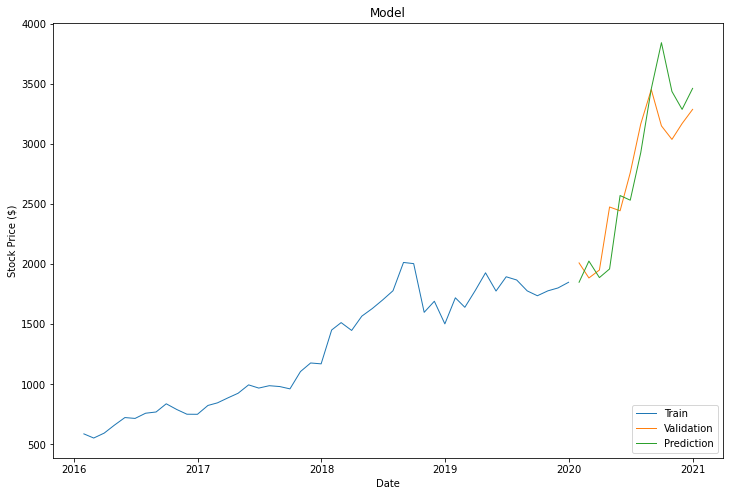

AMZN - Validation:                    AMZN  Predictions
Date                                
2020-01-31  2008.719971  1848.226196
2020-02-29  1883.750000  2024.042603
2020-03-31  1949.719971  1886.857544
2020-04-30  2474.000000  1958.750610
2020-05-31  2442.370117  2569.220947
2020-06-30  2758.820068  2530.594482
2020-07-31  3164.679932  2925.787842
2020-08-31  3450.959961  3455.969482
2020-09-30  3148.729980  3840.469971
2020-10-31  3036.149902  3434.753174
2020-11-30  3168.040039  3285.781738
2020-12-31  3285.850098  3460.442139
GOOGL - Train Data Shape: (48, 1)
GOOGL - Test Data Shape: (13, 1)
GOOGL - Train Data Sample: [0.05502103 0.01302725 0.05649604 0.0041394 ]
GOOGL - X_train Shape: (47, 1, 1)
GOOGL - y_train Shape: (47,)
GOOGL - X_train Sample: [[0.05502103]
 [0.01302725]
 [0.05649604]
 [0.0041394 ]
 [0.04312612]]
GOOGL - y_train Sample: [0.01302725 0.05649604 0.0041394  0.04312612 0.        ]
Epoch 1/10
47/47 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch

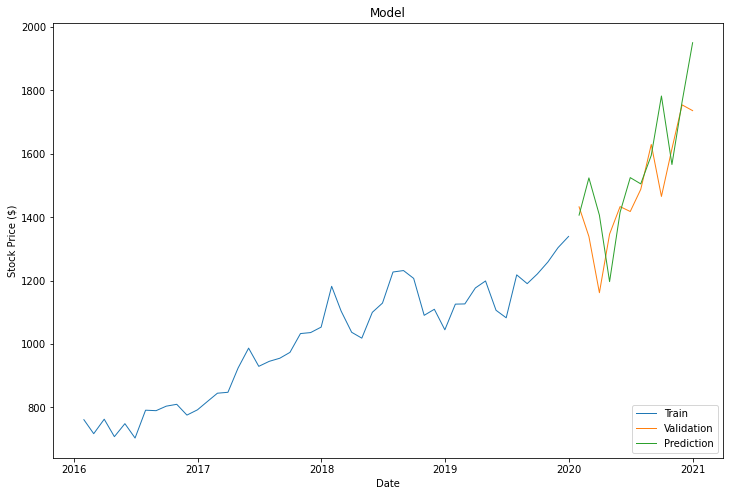

GOOGL - Validation:                   GOOGL  Predictions
Date                                
2020-01-31  1432.780029  1406.575439
2020-02-29  1339.250000  1524.033447
2020-03-31  1161.949951  1406.402710
2020-04-30  1346.699951  1196.898926
2020-05-31  1433.520020  1415.613892
2020-06-30  1418.050049  1524.980225
2020-07-31  1487.949951  1505.237305
2020-08-31  1629.530029  1595.218262
2020-09-30  1465.599976  1782.362793
2020-10-31  1616.109985  1566.238281
2020-11-30  1754.400024  1764.412720
2020-12-31  1736.250000  1950.573486
TSLA - Train Data Shape: (48, 1)
TSLA - Test Data Shape: (13, 1)
TSLA - Train Data Sample: [0.00183657 0.00205854 0.01356446 0.01690617]
TSLA - X_train Shape: (47, 1, 1)
TSLA - y_train Shape: (47,)
TSLA - X_train Sample: [[0.00183657]
 [0.00205854]
 [0.01356446]
 [0.01690617]
 [0.01157586]]
TSLA - y_train Sample: [0.00205854 0.01356446 0.01690617 0.01157586 0.00824632]
Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 9.8879e-04
Epoch 2

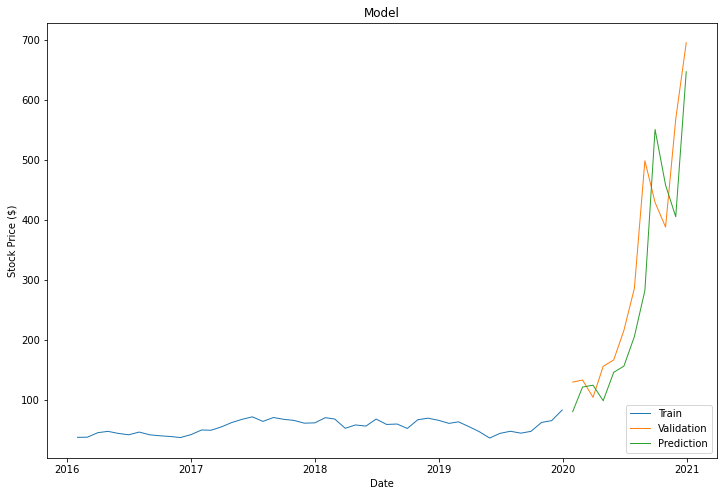

TSLA - Validation:                   TSLA  Predictions
Date                               
2020-01-31  130.113998    80.883453
2020-02-29  133.598007   121.786438
2020-03-31  104.800003   124.985291
2020-04-30  156.376007    99.092209
2020-05-31  167.000000   146.347412
2020-06-30  215.962006   156.576157
2020-07-31  286.152008   205.870331
2020-08-31  498.320007   282.515656
2020-09-30  429.010010   550.464844
2020-10-31  388.040009   457.852295
2020-11-30  567.599976   405.199677
2020-12-31  694.780029   646.524780
GM - Train Data Shape: (48, 1)
GM - Test Data Shape: (13, 1)
GM - Train Data Sample: [0.17066966 0.1634372  0.24965027 0.26319733]
GM - X_train Shape: (47, 1, 1)
GM - y_train Shape: (47,)
GM - X_train Sample: [[0.17066966]
 [0.1634372 ]
 [0.24965027]
 [0.26319733]
 [0.24415817]]
GM - y_train Sample: [0.1634372  0.24965027 0.26319733 0.24415817 0.14823937]
Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 2/10
47/47 [======================

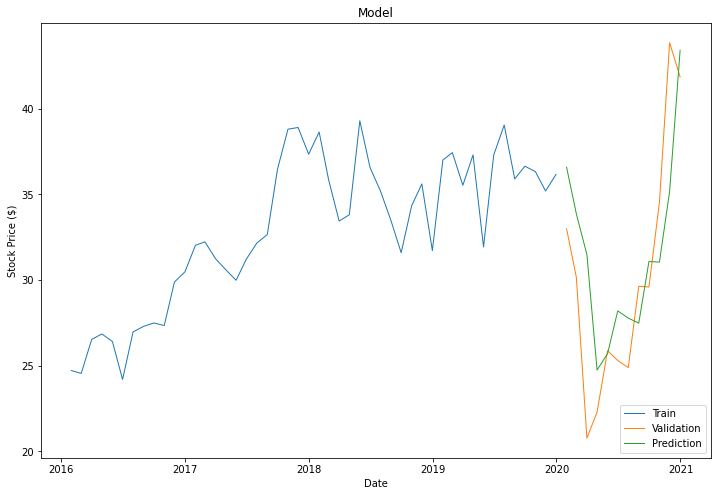

GM - Validation:                    GM  Predictions
Date                              
2020-01-31  32.987583    36.578979
2020-02-29  30.132414    33.844456
2020-03-31  20.780001    31.479475
2020-04-30  22.290001    24.744574
2020-05-31  25.879999    25.706383
2020-06-30  25.299999    28.197554
2020-07-31  24.889999    27.776451
2020-08-31  29.629999    27.482965
2020-09-30  29.590000    31.075399
2020-10-31  34.529999    31.043404
2020-11-30  43.840000    35.162945
2020-12-31  41.840000    43.397099
AAPL - Train Data Shape: (48, 1)
AAPL - Test Data Shape: (13, 1)
AAPL - Train Data Sample: [0.00639918 0.00613974 0.03173947 0.        ]
AAPL - X_train Shape: (47, 1, 1)
AAPL - y_train Shape: (47,)
AAPL - X_train Sample: [[0.00639918]
 [0.00613974]
 [0.03173947]
 [0.        ]
 [0.0140028 ]]
AAPL - y_train Sample: [0.00613974 0.03173947 0.         0.0140028  0.00508257]
Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 2/10
47/47 [========================

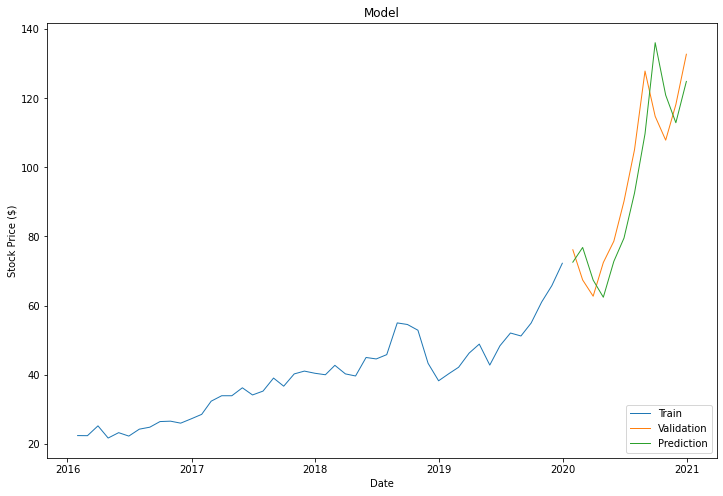

AAPL - Validation:                   AAPL  Predictions
Date                               
2020-01-31   76.147949    72.559090
2020-02-29   67.413651    76.817192
2020-03-31   62.710781    67.368454
2020-04-30   72.454391    62.413815
2020-05-31   78.619843    72.785118
2020-06-30   90.207321    79.542709
2020-07-31  105.103416    92.561699
2020-08-31  127.865585   109.697014
2020-09-30  114.755989   136.075714
2020-10-31  107.869247   120.901405
2020-11-30  118.170021   112.904686
2020-12-31  132.731598   124.864052
FB - Train Data Shape: (48, 1)
FB - Test Data Shape: (13, 1)
FB - Train Data Sample: [0.02839811 0.         0.03854413 0.0572257 ]
FB - X_train Shape: (47, 1, 1)
FB - y_train Shape: (47,)
FB - X_train Sample: [[0.02839811]
 [0.        ]
 [0.03854413]
 [0.0572257 ]
 [0.06382864]]
FB - y_train Sample: [0.         0.03854413 0.0572257  0.06382864 0.03951041]
Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 2/10
47/47 [======================

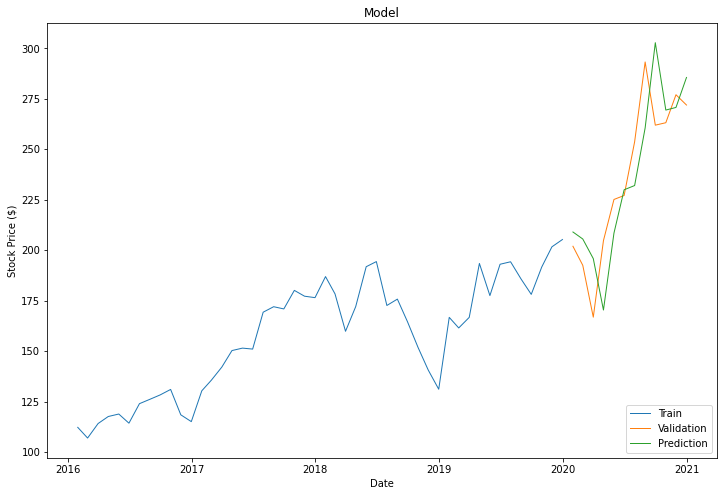

FB - Validation:                     FB  Predictions
Date                               
2020-01-31  201.910004   208.979385
2020-02-29  192.470001   205.509750
2020-03-31  166.800003   195.802567
2020-04-30  204.710007   170.325714
2020-05-31  225.089996   208.417282
2020-06-30  227.070007   229.888168
2020-07-31  253.669998   231.997070
2020-08-31  293.200012   260.528015
2020-09-30  261.899994   302.752686
2020-10-31  263.109985   269.377502
2020-11-30  276.970001   270.677490
2020-12-31  271.869995   285.526337
MCD - Train Data Shape: (48, 1)
MCD - Test Data Shape: (13, 1)
MCD - Train Data Sample: [0.0648476  0.02202771 0.08626543 0.09239409]
MCD - X_train Shape: (47, 1, 1)
MCD - y_train Shape: (47,)
MCD - X_train Sample: [[0.0648476 ]
 [0.02202771]
 [0.08626543]
 [0.09239409]
 [0.0588754 ]]
MCD - y_train Sample: [0.02202771 0.08626543 0.09239409 0.0588754  0.05255419]
Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 2/10
47/47 [=================

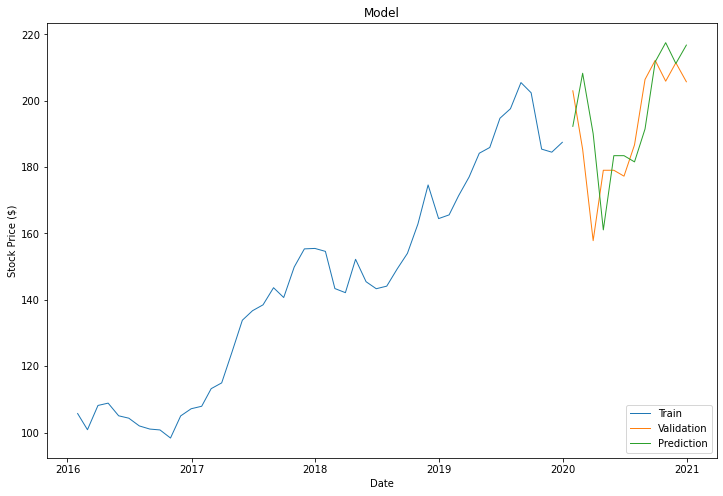

MCD - Validation:                    MCD  Predictions
Date                               
2020-01-31  202.959732   192.248764
2020-02-29  185.331146   208.245193
2020-03-31  157.823074   190.042709
2020-04-30  179.022034   161.061874
2020-05-31  179.024200   183.418365
2020-06-30  177.246658   183.420639
2020-07-31  186.672516   181.548141
2020-08-31  206.359390   191.445496
2020-09-30  212.129181   211.683212
2020-10-31  205.856812   217.451920
2020-11-30  211.396957   211.176682
2020-12-31  205.680374   216.724716
PFE - Train Data Shape: (48, 1)
PFE - Test Data Shape: (13, 1)
PFE - Train Data Sample: [0.0243471  0.00137809 0.         0.14099585]
PFE - X_train Shape: (47, 1, 1)
PFE - y_train Shape: (47,)
PFE - X_train Sample: [[0.0243471 ]
 [0.00137809]
 [0.        ]
 [0.14099585]
 [0.24744011]]
PFE - y_train Sample: [0.00137809 0.         0.14099585 0.24744011 0.27108365]
Epoch 1/10
47/47 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 2/10
47/47 [================

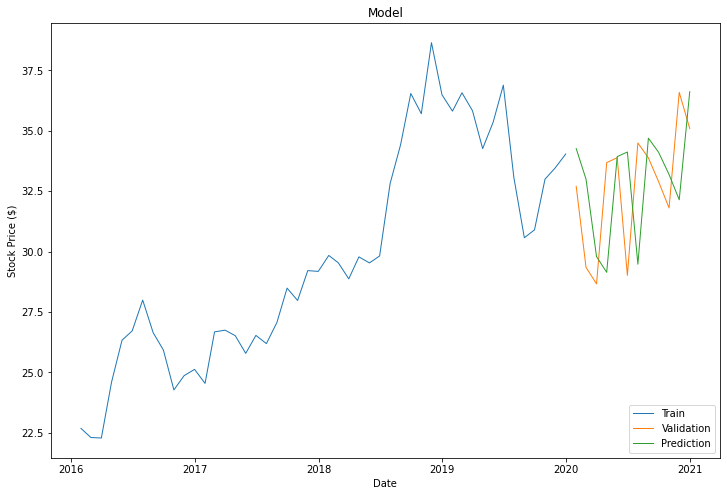

PFE - Validation:                   PFE  Predictions
Date                              
2020-01-31  32.698830    34.261597
2020-02-29  29.344656    32.996712
2020-03-31  28.659771    29.789434
2020-04-30  33.682251    29.138014
2020-05-31  33.885410    33.928856
2020-06-30  29.014214    34.120316
2020-07-31  34.494621    29.474703
2020-08-31  33.876087    34.691761
2020-09-30  32.898975    34.111542
2020-10-31  31.805338    33.187054
2020-11-30  36.589287    32.144093
2020-12-31  35.089806    36.617954


,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA
2016-01-31 00:00:00,22.379028,587.000000,112.209999,24.715643,761.349976,105.743866,22.677736,38.240002
2016-02-29 00:00:00,22.350214,552.520020,106.919998,24.548862,717.219971,100.872566,22.301815,38.386002
2016-03-31 00:00:00,25.193403,593.640015,114.099998,26.536936,762.900024,108.180412,22.279261,45.953999
2016-04-30 00:00:00,21.668314,659.590027,117.580002,26.849331,707.880005,108.877625,24.586863,48.152000
2016-05-31 00:00:00,23.223511,722.789978,118.809998,26.410288,748.849976,105.064453,26.328978,44.646000
...,...,...,...,...,...,...,...,...
2020-09-30 00:00:00,114.755989,3148.729980,261.899994,29.590000,1465.599976,212.129181,32.898975,429.010010
2020-10-31 00:00:00,107.869247,3036.149902,263.109985,34.529999,1616.109985,205.856812,31.805338,388.040009
2020-11-30 00:00:00,118.170021,3168.040039,276.970001,43.840000,1754.400024,211.396957,36.589287,567.599976
2020-12-31 00:00:00,132.731598,3285.850098,271.869995,41.840000,1736.250000,205.680374,35.089806,694.780029


In [ ]:
def predict_stock_price(stocks, historical_quotes_df, params={}):
  
  future_quotes_df = historical_quotes_df.copy()  
  model = build_model(params=params)
  model = compile_model(model)
  predict_dict = {}

  for stock in stocks:
    stock_info_df = getStockQuotesFromDataframe(historical_quotes_df, stock)
    scaled_quotes_arr = min_max_scale_data(stock_info_df)

    train_data_arr, test_data_arr, training_size = preprocess_data(scaled_quotes_arr, params['train_size'], params['window_size'])
    print(stock, "- Train Data Shape:", train_data_arr.shape)
    print(stock, "- Test Data Shape:",test_data_arr.shape)
    print(stock, "- Train Data Sample:",train_data_arr[0:4,0])

    X_train, y_train = split_data_X_Y(train_data_arr, params['window_size'])
    print(stock, "- X_train Shape:", X_train.shape)
    print(stock, "- y_train Shape:", y_train.shape)
    print(stock, "- X_train Sample:", X_train[0:5,0])
    print(stock, "- y_train Sample:", y_train[0:5])

    model, history = train_model(model,X_train, y_train, params['batch_size'], params['num_of_epochs'])

    test_predictions = test_and_predict(model, test_data_arr, stock)

    predict_dict[stock] = test_predictions[-1] #Prediction based on last value in testing dataset, which will give us next date

    train, valid = plot_result(stock_info_df, stock, training_size, test_predictions)

    print(stock,"- Validation:", valid)
    #End of for loop
  
  future_quotes_df = future_quotes_df.append(pd.DataFrame(predict_dict, index=[params['next_date']]))
  return future_quotes_df

params={# add parameters here
        "LSTM_1_units": 10,
        "LSTM_2_units": 10,   
	      "dense_layer_1_units": 10,
        "dense_layer_2_units":1,
        "window_size":1,
        "train_size":0.80,
        "num_of_epochs":10,
        "batch_size":1,
        "next_date":'2021-01-29 00:00:00'
        }
predicted_quotes_df = predict_stock_price(STOCKS_LIST, monthly_quote_df, params=params)
predicted_quotes_df

#Random Portfolios Generation

In [ ]:
def portfolio_monthly_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )*30
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(30)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(STOCKS_LIST))
        weights /= np.sum(weights)  #make sure the sum is 1
        weights_record.append(weights)
        portfolio_std, portfolio_return = portfolio_monthly_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, columns):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Monthly Return:", round(rp,2))
    print("Monthly STD:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum STD Portfolio Allocation\n")
    print("Monthly Return:", round(rp_min,2))
    print("Monthly STD:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='o',color='r',s=50, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='o',color='g',s=50, label='Minimum STD')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Monthly STD')
    plt.ylabel('Monthly returns')
    plt.legend(labelspacing=0.8)


# From the historical data, we can estimate the imputs needed for the MV Analysis:
1. expected returns ${\bf r}$
2. variance-covariance matrix $\Sigma$
3. we also need risk free interest rate $r_f$

We are generating num_portfolios random portfolios

In [ ]:
# Calculate all inputs needed for random portfolio generation
returns = predicted_quotes_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Monthly Return: 0.88
Monthly STD: 0.34


             AAPL   AMZN    FB    GM  GOOGL    MCD   PFE  TSLA
allocation  26.71  29.98  0.73  1.91   5.27  19.64  6.13  9.63
--------------------------------------------------------------------------------
Minimum STD Portfolio Allocation

Monthly Return: 0.51
Monthly STD: 0.24


            AAPL  AMZN    FB    GM  GOOGL    MCD    PFE  TSLA
allocation  13.4  8.79  2.31  6.47   0.46  40.98  27.31  0.28


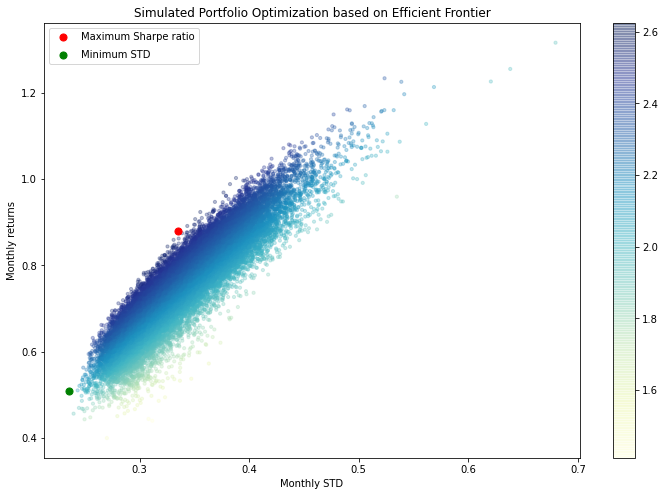

In [ ]:
#Calculate and display Efficient Frontier Portfolio
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, predicted_quotes_df.columns)

###Conclusion - Predicted Rate of Return


---


Monthly Return: 0.88



---

Stock Allocation:

*   AAPL (26.71)
*   AMZN (29.98)
*   FB (0.73)
*   GM (1.91)
*   GOOGL(5.27)
*   MCD (19.64)
*   PFE (6.13)
*   TSLA (9.63)


#Actual Rate of Return For Jan 2021

In [ ]:
daily_quote_updated_df = getQuotes(STOCKS_LIST, '2016-01-01', '2021-01-31', 'Adj Close', 'monthly')
daily_quote_updated_df

[*********************100%***********************]  8 of 8 completed


,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA
Date,,,,,,,,
2016-01-04,24.220577,636.989990,102.220001,27.775913,759.440002,100.447296,23.763655,44.681999
2016-01-05,23.613623,633.789978,102.730003,27.042114,761.530029,101.831223,23.934721,44.686001
2016-01-06,23.151512,632.650024,102.970001,26.074835,759.330017,101.147797,23.510767,43.807999
2016-01-07,22.174414,607.940002,97.919998,25.007492,741.000000,98.807053,23.354574,43.130001
2016-01-08,22.291670,607.049988,97.330002,24.623917,730.909973,98.653282,23.057064,42.200001
...,...,...,...,...,...,...,...,...
2021-01-25,141.863571,3294.000000,278.010010,53.389999,1894.280029,207.410904,35.605545,880.799988
2021-01-26,142.101822,3326.129883,282.049988,52.040001,1907.949951,209.394226,35.634201,883.090027
2021-01-27,141.009949,3232.580078,272.140015,49.340000,1818.939941,201.247101,34.612263,864.159973


In [ ]:
monthly_quote_updated_df = convert_daily_to_monthly_quotes_dataframe(daily_quote_updated_df)
returns_updated_df = calculate_returns(monthly_quote_updated_df)
returns_updated_df

,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA
Date,,,,,,,,
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,-0.001287,-0.058739,-0.047144,-0.006748,-0.057963,-0.046068,-0.016577,0.003818
2016-03-31,0.127211,0.074423,0.067153,0.080984,0.063690,0.072446,-0.001011,0.197155
2016-04-30,-0.139921,0.111094,0.030500,0.011772,-0.072120,0.006445,0.103577,0.047830
2016-05-31,0.071773,0.095817,0.010461,-0.016352,0.057877,-0.035023,0.070855,-0.072811
...,...,...,...,...,...,...,...,...
2020-09-30,-0.102526,-0.087579,-0.106753,-0.001350,-0.100600,0.027960,-0.028844,-0.139087
2020-10-31,-0.060012,-0.035754,0.004620,0.166948,0.102695,-0.029569,-0.033243,-0.095499
2020-11-30,0.095493,0.043440,0.052678,0.269621,0.085570,0.026913,0.150414,0.462736


In [ ]:
# Calculate all inputs needed for random portfolio generation - Actual Returns
mean_returns_actual = returns_updated_df.mean()
cov_matrix_actual = returns_updated_df.cov()
num_portfolios_actual = 25000
risk_free_rate = 0.0

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Monthly Return: 0.93
Monthly STD: 0.36


             AAPL   AMZN    FB    GM  GOOGL    MCD   PFE   TSLA
allocation  25.95  28.38  1.51  1.58   8.15  18.46  2.51  13.46
--------------------------------------------------------------------------------
Minimum STD Portfolio Allocation

Monthly Return: 0.44
Monthly STD: 0.24


            AAPL  AMZN    FB    GM  GOOGL    MCD    PFE  TSLA
allocation  2.23  4.88  2.67  5.97  29.09  28.24  26.54  0.38


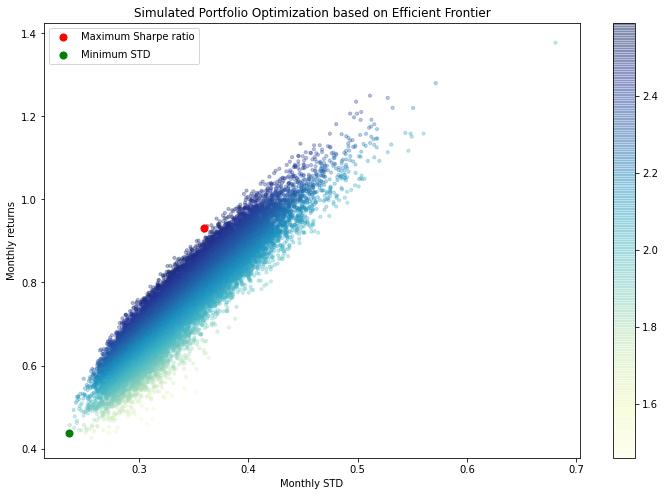

In [ ]:
#Calculate and display Efficient Frontier Portfolio
display_simulated_ef_with_random(mean_returns_actual, cov_matrix_actual, num_portfolios_actual, risk_free_rate, returns_updated_df.columns)

###Conclusion - Actual Rate of Return


---


Monthly Return: 0.93 (Predicted Return - 0.88)



---

Stock Allocation:

*   AAPL - 25.95 (Predicted - 26.71)
*   AMZN - 28.38 (Predicted - 29.98)
*   FB - 1.51 (Predicted - 0.73)
*   GM - 1.58 (Predicted - 1.91)
*   GOOGL - 8.15 (Predicted - 5.27)
*   MCD - 18.46 (Predicted - 19.64)
*   PFE - 2.51 (Predicted - 6.13)
*   TSLA - 13.46 (Predicted - 9.63)

